<a href="https://colab.research.google.com/github/DivS-15/Carbon-dioxide_prediction_model/blob/main/xg_boost_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exploratory Data Analysis



Correlation Heatmap to estimate important features

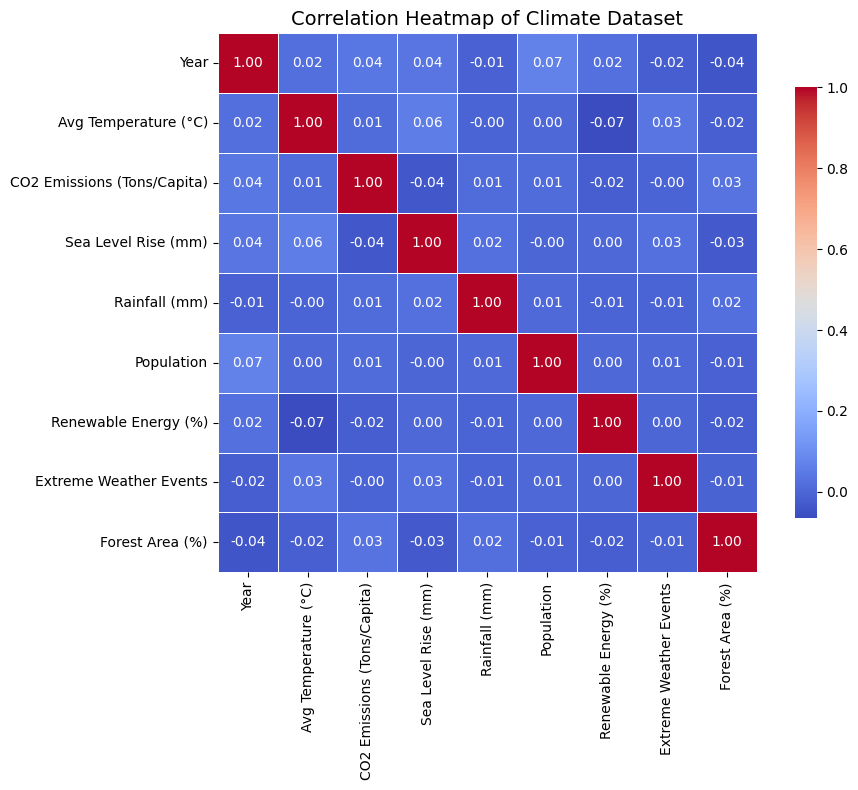

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load your dataset (skip if already loaded)
df = pd.read_csv('/climate_change_dataset.csv')

# Compute correlation matrix (numerical columns only)
corr_matrix = df.corr(numeric_only=True)

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(
    corr_matrix,
    annot=True,         # display correlation values
    fmt=".2f",          # format decimal places
    cmap='coolwarm',    # color scheme
    square=True,        # square cells
    linewidths=0.5,     # line spacing
    cbar_kws={"shrink": .8}  # colorbar sizing
)

plt.title("Correlation Heatmap of Climate Dataset", fontsize=14)
plt.tight_layout()
plt.show()


Very low correlations, Plot CO₂ vs Population (not per capita)

<Axes: xlabel='Population', ylabel='Total CO2 Emissions'>

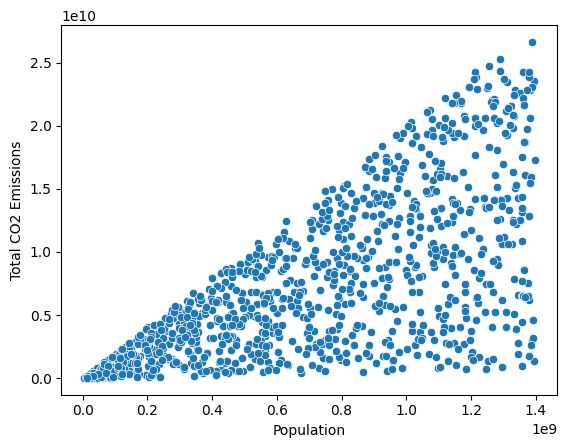

In [ ]:
df['Total CO2 Emissions'] = df['CO2 Emissions (Tons/Capita)'] * df['Population']
sns.scatterplot(x='Population', y='Total CO2 Emissions', data=df)


Use log-log scale to improve readability

Text(0.5, 1.0, 'Log-Scale: Population vs Total CO₂ Emissions')

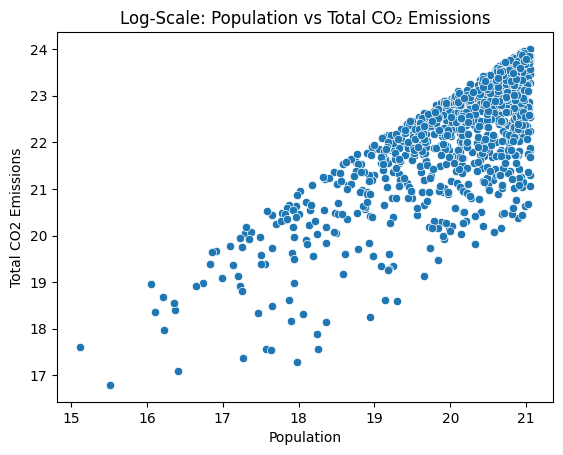

In [ ]:
sns.scatterplot(x=np.log1p(df['Population']), y=np.log1p(df['Total CO2 Emissions']))
plt.title("Log-Scale: Population vs Total CO₂ Emissions")


Inferences from the above log-log graph

More population means more CO2 emission (obvious, but confirmed)

* Total CO₂∝Population^k

for some exponent k ≈ 1

### Let's take renewable energy for these countries into account:

<Axes: xlabel='Population', ylabel='Total CO2 Emissions'>

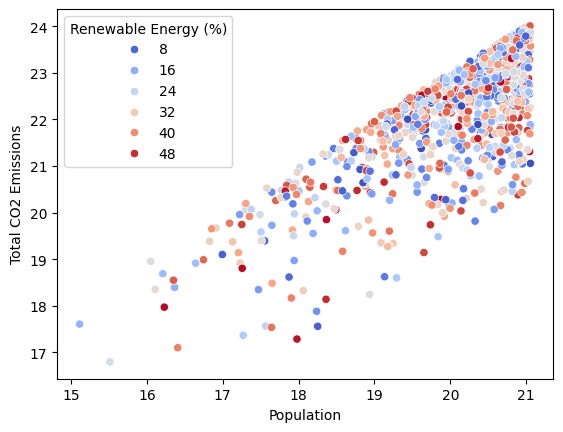

In [ ]:
sns.scatterplot(
    data=df,
    x=np.log1p(df['Population']),
    y=np.log1p(df['Total CO2 Emissions']),
    hue=df['Renewable Energy (%)'],
    palette='coolwarm'
)

### Renewable Energy Appears to Reduce CO₂ Emissions (Slightly)

*   Dark red = high renewable energy
*   Dark blue = low renewable energy

If you scan vertically (i.e., for a fixed population size):

* Blue points (low renewables) tend to lie higher on the y-axis

* Red points (high renewables) tend to lie lower, especially in the lower-left region


At a given population size, higher renewable share generally corresponds to lower total CO₂ emissions.

### Model Building
### BaseLine Model : Simple Moving Average


Baseline SMA Model Evaluation:
MAE  = 5.15
RMSE = 6.16
R²   = -0.20


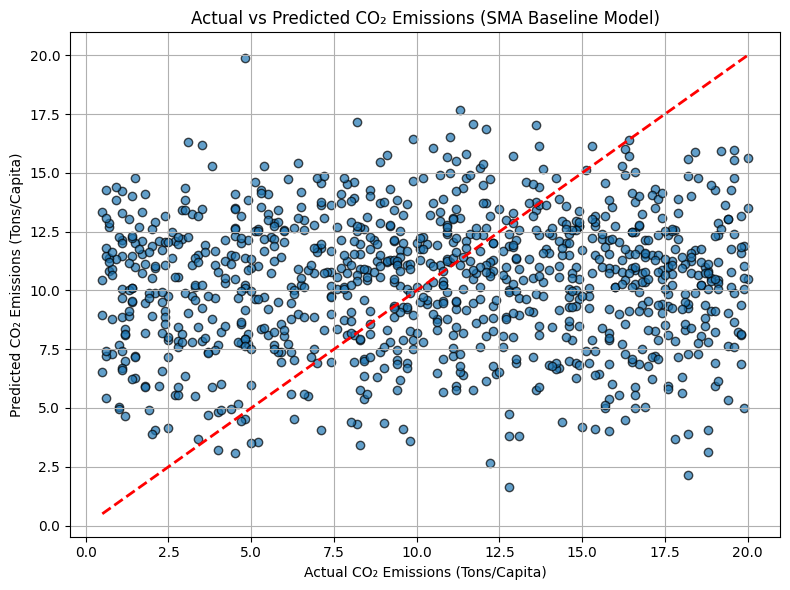

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np # Import numpy for sqrt function


# Load your dataset
df = pd.read_csv("climate_change_dataset.csv")

# Sort by Country and Year to ensure correct time ordering
df = df.sort_values(by=["Country", "Year"])

# Set parameters
window_size = 5  # You can change this to 5 or another value

# Create a new column for moving average prediction
df["CO2_SMA_Prediction"] = df.groupby("Country")["CO2 Emissions (Tons/Capita)"].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean().shift(1))

# Drop rows where prediction is NaN (optional)
df_clean = df.dropna(subset=["CO2_SMA_Prediction"])

# Evaluate the model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_true = df_clean["CO2 Emissions (Tons/Capita)"]
y_pred = df_clean["CO2_SMA_Prediction"]
y_pred_sma = y_pred

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)  # Calculate MSE
rmse = np.sqrt(mse)  # Calculate RMSE using numpy's sqrt
r2 = r2_score(y_true, y_pred)

print(f"Baseline SMA Model Evaluation:")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.2f}")

# Plot: Actual vs Predicted CO₂ Emissions (Global View)
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.7, edgecolor='k')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', linestyle='--', linewidth=2)
plt.xlabel("Actual CO₂ Emissions (Tons/Capita)")
plt.ylabel("Predicted CO₂ Emissions (Tons/Capita)")
plt.title("Actual vs Predicted CO₂ Emissions (SMA Baseline Model)")
plt.grid(True)
plt.tight_layout()
plt.show()



### Linear Regression (Baseline model to set a bar for further improvement)


Final Model RMSE with Averaged Parameters: 3.53
Final Model RMSE with Averaged Parameters: 3.53
R² Score: 0.24


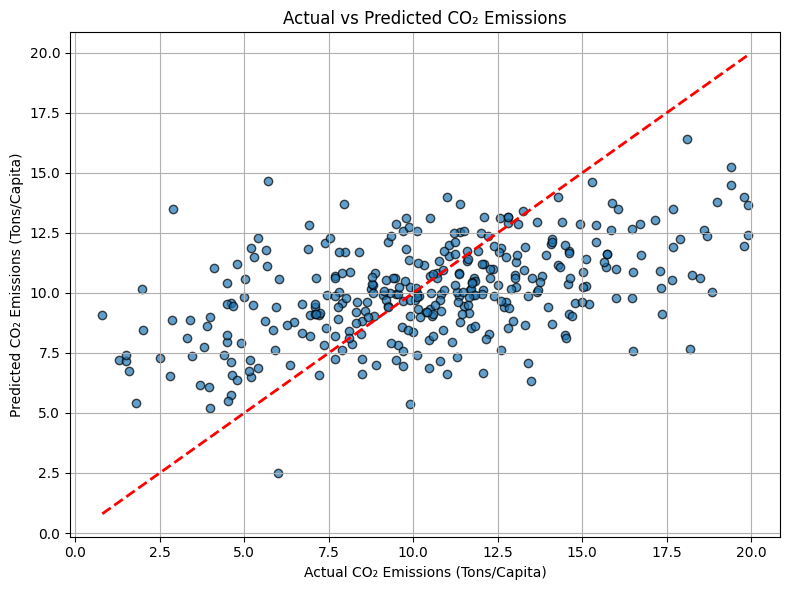

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error

# Load data
df = pd.read_csv('climate_change_dataset.csv')

# Handle duplicates by averaging
df_clean = df.groupby(['Year', 'Country'], as_index=False).mean()

# Split features and target
X = df_clean.drop(columns=['CO2 Emissions (Tons/Capita)'])
y = df_clean['CO2 Emissions (Tons/Capita)']

# Define numeric and categorical columns
numeric_features = ['Year', 'Avg Temperature (°C)', 'Sea Level Rise (mm)',
                    'Rainfall (mm)', 'Population', 'Renewable Energy (%)',
                    'Extreme Weather Events', 'Forest Area (%)']
categorical_features = ['Country']

from sklearn.preprocessing import PolynomialFeatures
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('scale', MinMaxScaler())
    ]), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])



# Full pipeline: preprocessing + linear regression
model = Pipeline([
    ('preprocess', preprocessor),
    ('regressor', LinearRegression())
])

# Store coefficients and intercepts
coefs = []
intercepts = []

# 7-fold cross-validation
kf = KFold(n_splits=7, shuffle=True, random_state=42)
for train_idx, _ in kf.split(X):
    X_train = X.iloc[train_idx]
    y_train = y.iloc[train_idx]

    model.fit(X_train, y_train)
    coefs.append(model.named_steps['regressor'].coef_)
    intercepts.append(model.named_steps['regressor'].intercept_)

# Average the parameters
avg_coef = np.mean(coefs, axis=0)
avg_intercept = np.mean(intercepts)

# Train final model on full data
final_model = model.fit(X, y)
final_model.named_steps['regressor'].coef_ = avg_coef
final_model.named_steps['regressor'].intercept_ = avg_intercept

# Predict and evaluate
y_pred = final_model.predict(X)
y_pred_linear = y_pred
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"Final Model RMSE with Averaged Parameters: {rmse:.2f}")


import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Predict and evaluate
y_pred = final_model.predict(X)
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

print(f"Final Model RMSE with Averaged Parameters: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# Plot actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred, alpha=0.7, edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', linewidth=2)
plt.xlabel("Actual CO₂ Emissions (Tons/Capita)")
plt.ylabel("Predicted CO₂ Emissions (Tons/Capita)")
plt.title("Actual vs Predicted CO₂ Emissions")
plt.grid(True)
plt.tight_layout()
plt.show()


### Now, we use XGBoost model with target encoding instead of one-hot encoding the country column and applying log-transform to remove skewness

In [ ]:
!pip install category_encoders


### XG Boost Code


 Cross-validated RMSEs: [1.24 1.74 1.51 1.23 1.29 1.19 1.23]
 Average CV RMSE: 1.35
 Final RMSE on Full Training Data: 0.81
 Final R² Score on Full Training Data: 0.9593

🔍 Sample Predictions:
   Actual CO2 Emissions  Predicted CO2 Emissions
0                  3.90                     3.91
1                 10.47                    10.43
2                 14.60                    14.04
3                  8.85                     9.04
4                  6.93                     6.51
5                 14.60                    14.77
6                  5.95                     5.74
7                 12.25                    12.83
8                 13.94                    13.63
9                  4.40                     4.88


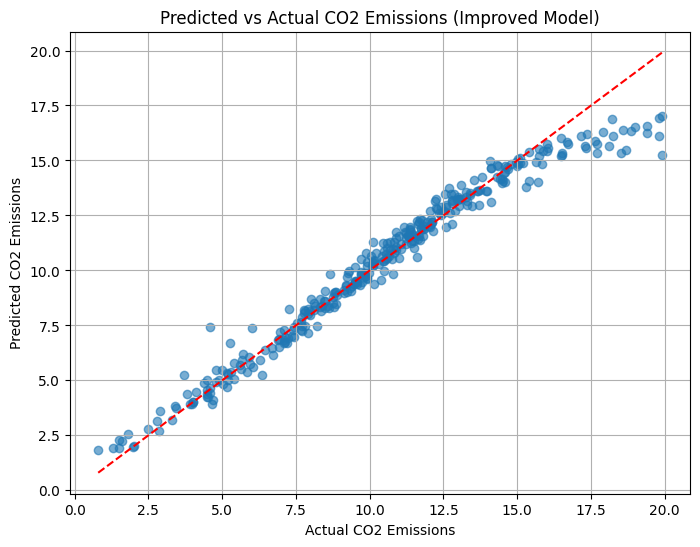

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.metrics import mean_squared_error, r2_score
from category_encoders import TargetEncoder
from xgboost import XGBRegressor

# Load and clean data
df = pd.read_csv('/climate_change_dataset.csv')
df_clean = df.groupby(['Year', 'Country'], as_index=False).mean()

# Add derived features
df_clean['CO2 per Capita Proxy'] = df_clean['CO2 Emissions (Tons/Capita)'] / (df_clean['Population'] + 1)
df_clean['Energy Intensity'] = df_clean['CO2 Emissions (Tons/Capita)'] / (df_clean['Renewable Energy (%)'] + 1)

# Features and target
y = np.log1p(df_clean['CO2 Emissions (Tons/Capita)'])  # log-transform target
X = df_clean.drop(columns=['CO2 Emissions (Tons/Capita)'])

# Feature groups
numeric_features = [
    'Year', 'Avg Temperature (°C)', 'Sea Level Rise (mm)', 'Rainfall (mm)',
    'Population', 'Renewable Energy (%)', 'Extreme Weather Events',
    'Forest Area (%)', 'CO2 per Capita Proxy', 'Energy Intensity'
]
log_features = ['Population', 'Rainfall (mm)', 'Extreme Weather Events']
categorical_features = ['Country']

# Transformers
log_transformer = FunctionTransformer(np.log1p, validate=True)

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('log_num', Pipeline([
        ('log', log_transformer),
        ('scale', MinMaxScaler())
    ]), log_features),

    ('num', MinMaxScaler(), list(set(numeric_features) - set(log_features))),

    ('cat', TargetEncoder(), categorical_features)
])

# XGBRegressor
xgb = XGBRegressor(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    reg_alpha=1,
    reg_lambda=10,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)

# Full pipeline
model = Pipeline([
    ('preprocess', preprocessor),
    ('regressor', xgb)
])

# K-fold cross-validation
kf = KFold(n_splits=7, shuffle=True, random_state=42)
rmse_scores = []

for train_idx, val_idx in kf.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model.fit(X_train, y_train)
    y_pred_log = model.predict(X_val)
    y_pred = np.expm1(y_pred_log)
    y_val_actual = np.expm1(y_val)

    rmse = np.sqrt(mean_squared_error(y_val_actual, y_pred))
    rmse_scores.append(rmse)

# Final model training
model.fit(X, y)
y_pred_log_final = model.predict(X)
y_pred_final = np.expm1(y_pred_log_final)
y_pred_xgb = y_pred_final
y_actual = np.expm1(y)

# Final metrics
rmse_final = np.sqrt(mean_squared_error(y_actual, y_pred_final))
r2 = r2_score(y_actual, y_pred_final)

print(f"\n Cross-validated RMSEs: {np.round(rmse_scores, 2)}")
print(f" Average CV RMSE: {np.mean(rmse_scores):.2f}")
print(f" Final RMSE on Full Training Data: {rmse_final:.2f}")
print(f" Final R² Score on Full Training Data: {r2:.4f}")

# Preview results
comparison_df = pd.DataFrame({
    'Actual CO2 Emissions': y_actual,
    'Predicted CO2 Emissions': y_pred_final
}).round(2)

print("\n🔍 Sample Predictions:")
print(comparison_df.head(10))

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_actual, y_pred_final, alpha=0.6)
plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--')
plt.xlabel("Actual CO2 Emissions")
plt.ylabel("Predicted CO2 Emissions")
plt.title("Predicted vs Actual CO2 Emissions (Improved Model)")
plt.grid(True)
plt.show()


combined Graph

In [ ]:
!pip install shap

### Model analysis for feature importance

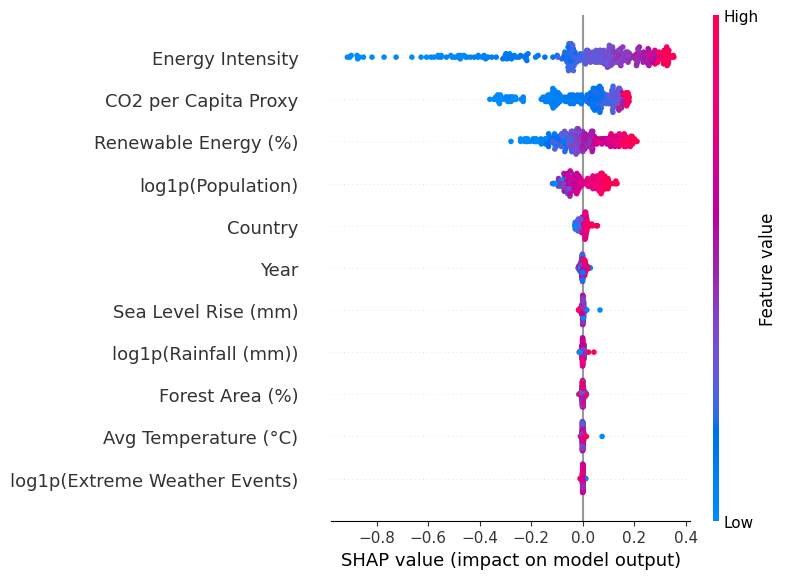

📊 Average CV RMSE: 1.35
⚠️ Final RMSE on Full Training Data: 0.81
⚠️ Final R² Score on Full Training Data: 0.9593

🔍 Sample Predictions:
   Actual CO2 Emissions  Predicted CO2 Emissions
0                  3.90                     3.91
1                 10.47                    10.43
2                 14.60                    14.04
3                  8.85                     9.04
4                  6.93                     6.51
5                 14.60                    14.77
6                  5.95                     5.74
7                 12.25                    12.83
8                 13.94                    13.63
9                  4.40                     4.88


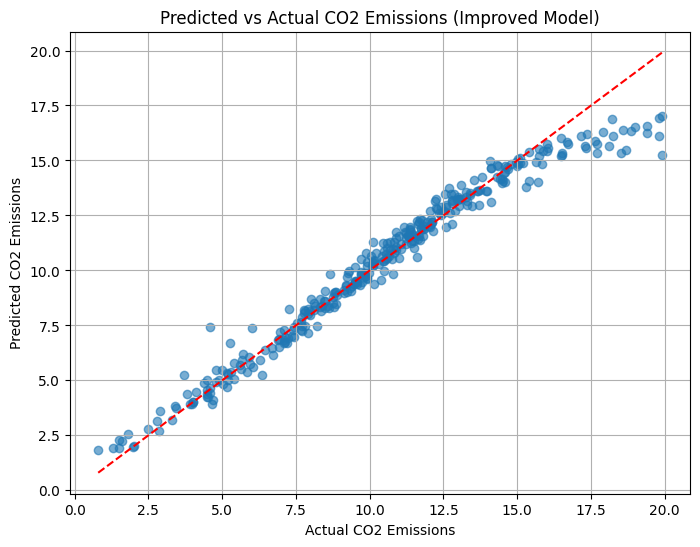

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.metrics import mean_squared_error, r2_score
from category_encoders import TargetEncoder
from xgboost import XGBRegressor
import shap

# Load and clean data
df = pd.read_csv('/climate_change_dataset.csv')
df_clean = df.groupby(['Year', 'Country'], as_index=False).mean()

# Add derived features (optional but recommended)
df_clean['CO2 per Capita Proxy'] = df_clean['CO2 Emissions (Tons/Capita)'] / (df_clean['Population'] + 1)
df_clean['Energy Intensity'] = df_clean['CO2 Emissions (Tons/Capita)'] / (df_clean['Renewable Energy (%)'] + 1)

# Features and target
y = np.log1p(df_clean['CO2 Emissions (Tons/Capita)'])  # log-transform target
X = df_clean.drop(columns=['CO2 Emissions (Tons/Capita)'])

# Feature groups
numeric_features = [
    'Year', 'Avg Temperature (°C)', 'Sea Level Rise (mm)', 'Rainfall (mm)',
    'Population', 'Renewable Energy (%)', 'Extreme Weather Events',
    'Forest Area (%)', 'CO2 per Capita Proxy', 'Energy Intensity'
]
log_features = ['Population', 'Rainfall (mm)', 'Extreme Weather Events']
categorical_features = ['Country']

# Transformers
log_transformer = FunctionTransformer(np.log1p, validate=True)

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('log_num', Pipeline([
        ('log', log_transformer),
        ('scale', MinMaxScaler())
    ]), log_features),

    ('num', MinMaxScaler(), list(set(numeric_features) - set(log_features))),

    ('cat', TargetEncoder(), categorical_features)
])

# XGBRegressor
xgb = XGBRegressor(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    reg_alpha=1,
    reg_lambda=10,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)

# Full pipeline
model = Pipeline([
    ('preprocess', preprocessor),
    ('regressor', xgb)
])

# K-fold cross-validation
kf = KFold(n_splits=7, shuffle=True, random_state=42)
rmse_scores = []

for train_idx, val_idx in kf.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model.fit(X_train, y_train)
    y_pred_log = model.predict(X_val)
    y_pred = np.expm1(y_pred_log)
    y_val_actual = np.expm1(y_val)

    rmse = np.sqrt(mean_squared_error(y_val_actual, y_pred))
    rmse_scores.append(rmse)

# Final model training
model.fit(X, y)
y_pred_log_final = model.predict(X)
y_pred_final = np.expm1(y_pred_log_final)
y_actual = np.expm1(y)

# Final metrics
rmse_final = np.sqrt(mean_squared_error(y_actual, y_pred_final))
r2 = r2_score(y_actual, y_pred_final)


# Fit your model first on full data
model.fit(X, y)

# Transform input data
X_transformed = model.named_steps['preprocess'].transform(X)

# Manual feature names
log_features = ['Population', 'Rainfall (mm)', 'Extreme Weather Events']
other_numeric = list(set(numeric_features) - set(log_features))
categorical = ['Country']

feature_names = (
    [f"log1p({feat})" for feat in log_features] +
    other_numeric +
    categorical
)

# Run SHAP explainer
explainer = shap.Explainer(model.named_steps['regressor'])
shap_values = explainer(X_transformed)

# SHAP summary plot
shap.summary_plot(shap_values, features=X_transformed, feature_names=feature_names)

print(f"📊 Average CV RMSE: {np.mean(rmse_scores):.2f}")
print(f"⚠️ Final RMSE on Full Training Data: {rmse_final:.2f}")
print(f"⚠️ Final R² Score on Full Training Data: {r2:.4f}")

# Preview results
comparison_df = pd.DataFrame({
    'Actual CO2 Emissions': y_actual,
    'Predicted CO2 Emissions': y_pred_final
}).round(2)

print("\n🔍 Sample Predictions:")
print(comparison_df.head(10))

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_actual, y_pred_final, alpha=0.6)
plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--')
plt.xlabel("Actual CO2 Emissions")
plt.ylabel("Predicted CO2 Emissions")
plt.title("Predicted vs Actual CO2 Emissions (Improved Model)")
plt.grid(True)
plt.show()

Parameter Importance(average Gini index)

<ipython-input-38-d6054073e600>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, y='Feature', x='Importance', palette='viridis')


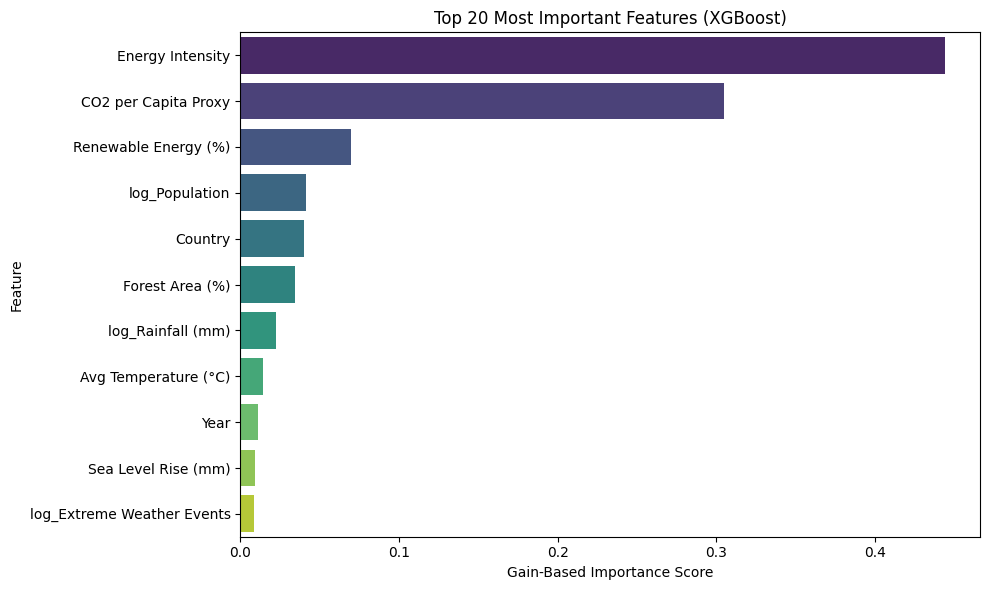


📈 Top 20 Feature Importances:

Energy Intensity                    → 0.44385
CO2 per Capita Proxy                → 0.30456
Renewable Energy (%)                → 0.06947
log_Population                      → 0.04120
Country                             → 0.04016
Forest Area (%)                     → 0.03455
log_Rainfall (mm)                   → 0.02254
Avg Temperature (°C)                → 0.01459
Year                                → 0.01109
Sea Level Rise (mm)                 → 0.00923
log_Extreme Weather Events          → 0.00876


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get the trained XGBoost model from the pipeline
xgb_model = model.named_steps['regressor']

# Get transformed feature names
# This requires handling each transformer step manually
# You can use the `get_feature_names_out` from sklearn if supported, or manually reconstruct
# Here's a basic manual way for this case:

transformed_features = []

# Log-transformed numeric features
transformed_features += ['log_' + f for f in log_features]

# Remaining numeric features
transformed_features += list(set(numeric_features) - set(log_features))

# Encoded categorical features (TargetEncoder doesn't expose names, so we just use original names here)
transformed_features += categorical_features

# Get feature importances
importances = xgb_model.feature_importances_

# Combine and sort
importance_df = pd.DataFrame({
    'Feature': transformed_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot top N
top_n = 20
top_features = importance_df.head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, y='Feature', x='Importance', palette='viridis')
plt.title(f"Top {top_n} Most Important Features (XGBoost)")
plt.xlabel("Gain-Based Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Print values
print(f"\n📈 Top {top_n} Feature Importances:\n")
for _, row in top_features.iterrows():
    print(f"{row['Feature']:<35} → {row['Importance']:.5f}")


Developing and Developed Countries Comparison

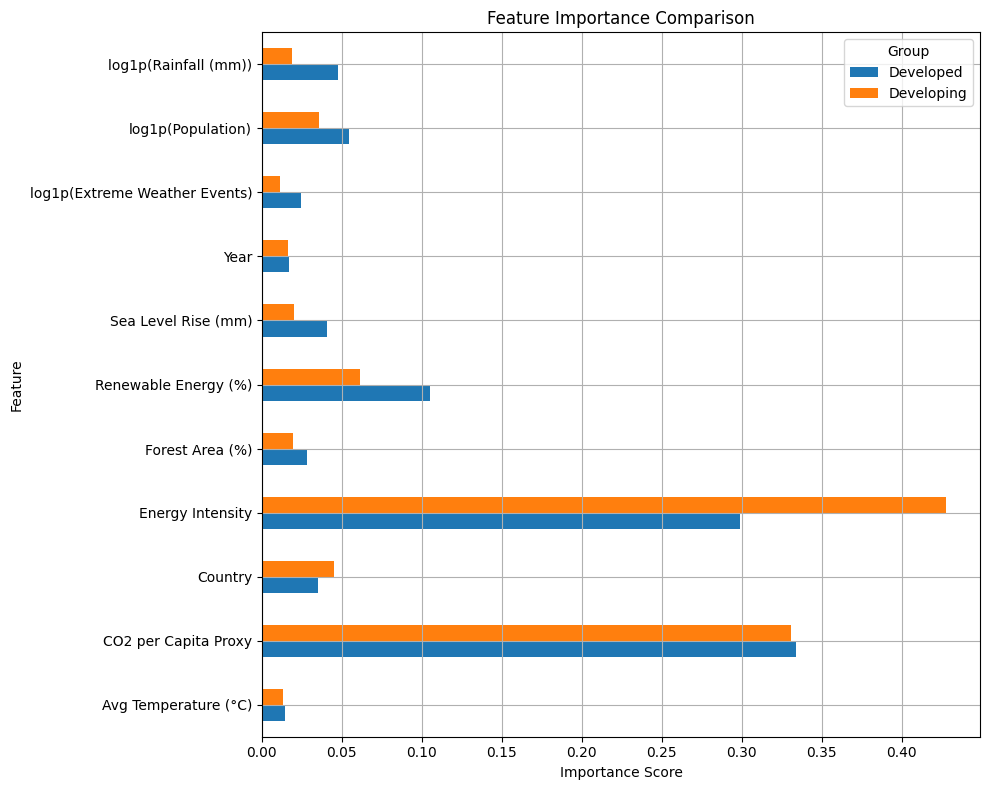

In [ ]:
# Split country groups
developed = ['USA', 'Germany', 'UK', 'Canada', 'France']
developing = ['India', 'China', 'Brazil', 'Argentina', 'South Africa',
              'Indonesia', 'Mexico', 'Nigeria', 'Bangladesh', 'Philippines']

df_clean['Group'] = df_clean['Country'].apply(lambda c: 'Developed' if c in developed else 'Developing')

# Helper function to get feature importance for a group
def get_group_feature_importance(group_name):
    group_df = df_clean[df_clean['Group'] == group_name]

    y_group = np.log1p(group_df['CO2 Emissions (Tons/Capita)'])
    X_group = group_df.drop(columns=['CO2 Emissions (Tons/Capita)', 'Group'])

    model.fit(X_group, y_group)
    xgb_model = model.named_steps['regressor']

    # Feature name reconstruction
    log_scaled_features = [f"log1p({col})" for col in log_features]
    direct_scaled_features = list(set(numeric_features) - set(log_features))
    encoded_cat_features = categorical_features  # TargetEncoder → 1 feature per cat
    feature_names_group = log_scaled_features + direct_scaled_features + encoded_cat_features

    return pd.DataFrame({
        'Feature': feature_names_group,
        'Importance': xgb_model.feature_importances_,
        'Group': group_name
    }).sort_values(by='Importance', ascending=False)

# Get importances
importance_dev = get_group_feature_importance('Developed')
importance_devp = get_group_feature_importance('Developing')

# Combine and compare
combined_importance = pd.concat([importance_dev, importance_devp])
pivot_importance = combined_importance.pivot(index='Feature', columns='Group', values='Importance').fillna(0)

# Visual comparison
pivot_importance.plot(kind='barh', figsize=(10, 8), title='Feature Importance Comparison')
plt.xlabel("Importance Score")
plt.grid(True)
plt.tight_layout()
plt.show()
